In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import IsolationForest

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Hyperparameters
BATCH_SIZE = 100
LR = 0.01
MOMENTUM = 0.9
NUM_CLIENTS = 100
CLIENTS_PER_ROUND = 10
LOCAL_EPOCHS = 1
ROUNDS = 15

Using device: cuda


In [2]:
def get_fresh_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_data = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_data = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)
    return train_data, test_data

def iid_partition(dataset, num_clients):
    num_items = int(len(dataset) / num_clients)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_clients):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    client_datasets = [Subset(dataset, list(dict_users[i])) for i in range(num_clients)]
    return client_datasets

class PoisonedDataset(Dataset):
    def __init__(self, dataset, base_label=7, target_label=1, mode='none', poison_ratio=0.1):
        """
        mode: 
         - 'none': No poisoning (clean).
         - 'patch': Add trigger + swap label (Backdoor).
         - 'flip': Swap label only (Label Flip).
        """
        self.dataset = dataset
        self.base_label = base_label
        self.target_label = target_label
        self.mode = mode
        self.poison_ratio = poison_ratio

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        # Attack Logic
        if self.mode == 'flip':
            # Label Flip: Only flip if original label is base_label
            # (e.g. Turn all 7s into 1s)
            if label == self.base_label:
                if random.random() < self.poison_ratio:
                    label = self.target_label
        
        elif self.mode == 'patch':
            # Backdoor Patch: Apply to ANY image with probability poison_ratio
            if random.random() < self.poison_ratio:
                img = self.add_trigger(img)
                label = self.target_label
        
        return img, label

    def add_trigger(self, img):
        # Add 2x2 white pixel trigger at bottom right
        pixel_val = 2.8  # approx 255 in normalized space
        img = img.clone()
        img[:, 26:28, 26:28] = pixel_val
        return img

In [3]:
def aggregate_avg(client_weights):
    num_clients = len(client_weights)
    avg_weights = copy.deepcopy(client_weights[0])
    for key in avg_weights.keys():
        for i in range(1, num_clients):
            avg_weights[key] += client_weights[i][key]
        avg_weights[key] = torch.div(avg_weights[key], num_clients)
    return avg_weights

def aggregate_median(client_weights):
    keys = client_weights[0].keys()
    median_weights = {}
    for key in keys:
        stacked = torch.stack([cw[key] for cw in client_weights], dim=0)
        median_weights[key] = torch.median(stacked, dim=0).values
    return median_weights

def aggregate_svd(client_weights, global_weights):
    """Simple SVD-based filtering: Remove outliers in update space."""
    # 1. Compute Updates
    deltas = []
    for cw in client_weights:
        vec = []
        for k in cw.keys():
            vec.append((cw[k] - global_weights[k]).float().cpu().flatten())
        deltas.append(torch.cat(vec))
    
    update_matrix = torch.stack(deltas).numpy()
    
    # 2. SVD & Filtering
    # Dynamically size components to avoid crash when clients < 5
    n_clients = update_matrix.shape[0]
    n_components = min(3, n_clients - 1) if n_clients > 1 else 1
    
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced = svd.fit_transform(update_matrix)
    
    # Assume ~20-30% malicious
    clf = IsolationForest(contamination=0.3, random_state=42)
    preds = clf.fit_predict(reduced) # 1 = inlier
    
    keep_idxs = [i for i, p in enumerate(preds) if p == 1]
    if len(keep_idxs) == 0: keep_idxs = list(range(n_clients)) # Fallback
    
    # 3. Average Inliers
    accepted = [client_weights[i] for i in keep_idxs]
    return aggregate_avg(accepted)

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_client(model, train_loader, epochs, lr, is_malicious=False, apply_scaling=False):
    """
    Trains a client.
    If constrain_scale is True, it boosts the update magnitude using vector operations.
    """
    # 1. Capture global model state as a vector before training
    global_vec = nn.utils.parameters_to_vector(model.parameters()).clone().detach()

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM)
    criterion = nn.CrossEntropyLoss()

    # 2. Local Training Loop
    for _ in range(epochs):
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

    # 3. Constrain-and-Scale Attack (Vectorized)
    if is_malicious and apply_scaling:
        scale_attack = 2.5  # Scaling factor
        
        with torch.no_grad():
            # Get the trained local parameters as a vector
            local_vec = nn.utils.parameters_to_vector(model.parameters())
            
            # Calculate update vector
            delta = local_vec - global_vec
            
            # Scale the update and apply it to the original global weights
            scaled_vec = global_vec + scale_attack * delta
            
            # Load the scaled weights back into the model
            nn.utils.vector_to_parameters(scaled_vec, model.parameters())

    return model.state_dict()

def evaluate(model, loader, target_label=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            out = model(imgs)
            preds = out.argmax(1)
            total += labels.size(0)
            if target_label is not None:
                # Success = predicted target
                correct += (preds == target_label).sum().item()
            else:
                # Accuracy = predicted correct label
                correct += (preds == labels).sum().item()
    return correct / total if total > 0 else 0


In [5]:
def run_experiment(defense='avg', attack='patch', mal_ratio=0.2):
    print(f"\n=== Exp: Defense={defense}, Attack={attack} ===")
    
    # 1. Fresh Data
    train_data, test_data = get_fresh_data()
    client_datasets = iid_partition(train_data, NUM_CLIENTS)
    
    # 2. Setup Attackers
    num_mal = int(NUM_CLIENTS * mal_ratio)
    mal_ids = list(range(num_mal))
    
    client_loaders = []
    for i in range(NUM_CLIENTS):
        ds = client_datasets[i]
        
        # Determine poisoning mode for this client
        mode = 'none'
        poison_ratio = 0.0
        
        if i in mal_ids:
            if attack == 'patch':
                mode = 'patch'
                poison_ratio = 0.5
            elif attack == 'flip':
                mode = 'flip'
                poison_ratio = 1.0 # Flip ALL 7s to 1s for these clients
            elif attack == 'constrain':
                mode = 'patch' # Constrain uses patch trigger + weight scaling
                poison_ratio = 0.5
        
        # Wrap dataset
        p_ds = PoisonedDataset(ds, base_label=7, target_label=1, 
                               mode=mode, poison_ratio=poison_ratio)
        client_loaders.append(DataLoader(p_ds, batch_size=BATCH_SIZE, shuffle=True))

    # 3. Setup Validation Sets
    # Clean Test
    clean_test_loader = DataLoader(test_data, batch_size=256)
    
    # Backdoor Test (All images have trigger, Label=Target)
    # Only relevant for Patch/Constrain attacks
    bd_ds = PoisonedDataset(test_data, target_label=1, mode='patch', poison_ratio=1.0)
    bd_test_loader = DataLoader(bd_ds, batch_size=256)
    
    # Label Flip Test (All 7s, we check if they are predicted as 1)
    # Extract only 7s from test data
    sevens_idx = [i for i in range(len(test_data)) if test_data.targets[i] == 7]
    sevens_ds = Subset(test_data, sevens_idx)
    flip_test_loader = DataLoader(sevens_ds, batch_size=256)

    # 4. Training Loop
    global_model = CNN().to(DEVICE)
    acc_log, asr_log = [], []

    for r in range(ROUNDS):
        global_weights = global_model.state_dict()
        clients = np.random.choice(range(NUM_CLIENTS), CLIENTS_PER_ROUND, replace=False)
        
        collected_weights = []
        
        for c in clients:
            is_mal = (c in mal_ids)
            # Only scale if attack is 'constrain' AND client is malicious
            do_scale = (is_mal and attack == 'constrain')
            
            w = train_client(copy.deepcopy(global_model), client_loaders[c], 
                             LOCAL_EPOCHS, LR, is_mal, do_scale)
            collected_weights.append(w)
            
        # Aggregation
        if defense == 'avg':
            new_w = aggregate_avg(collected_weights)
        elif defense == 'median':
            new_w = aggregate_median(collected_weights)
        elif defense == 'svd':
            new_w = aggregate_svd(collected_weights, global_weights)
            
        global_model.load_state_dict(new_w)
        
        # Metrics
        acc = evaluate(global_model, clean_test_loader)
        
        # ASR depends on attack type
        if attack == 'flip':
            # Measure how many 7s are predicted as 1s
            asr = evaluate(global_model, flip_test_loader, target_label=1)
        else:
            # Measure how many triggered images are predicted as 1s
            asr = evaluate(global_model, bd_test_loader, target_label=1)
            
        acc_log.append(acc)
        asr_log.append(asr)
        print(f"Round {r}: Acc={acc:.2f} | ASR={asr:.2f}")

    return acc_log, asr_log

Starting comprehensive benchmark sweep (4 attacks x 3 defenses)...

--- Evaluation: Attack=NONE | Defense=AVG ---

=== Exp: Defense=avg, Attack=none ===
Round 0: Acc=0.49 | ASR=0.07
Round 1: Acc=0.65 | ASR=0.12
Round 2: Acc=0.70 | ASR=0.13
Round 3: Acc=0.76 | ASR=0.16
Round 4: Acc=0.80 | ASR=0.13
Round 5: Acc=0.82 | ASR=0.12
Round 6: Acc=0.86 | ASR=0.12
Round 7: Acc=0.88 | ASR=0.12
Round 8: Acc=0.88 | ASR=0.12
Round 9: Acc=0.88 | ASR=0.12
Round 10: Acc=0.90 | ASR=0.12
Round 11: Acc=0.90 | ASR=0.12
Round 12: Acc=0.91 | ASR=0.11
Round 13: Acc=0.91 | ASR=0.12
Round 14: Acc=0.91 | ASR=0.12

--- Evaluation: Attack=NONE | Defense=MEDIAN ---

=== Exp: Defense=median, Attack=none ===
Round 0: Acc=0.30 | ASR=0.07
Round 1: Acc=0.47 | ASR=0.10
Round 2: Acc=0.64 | ASR=0.12
Round 3: Acc=0.65 | ASR=0.11
Round 4: Acc=0.73 | ASR=0.13
Round 5: Acc=0.77 | ASR=0.17
Round 6: Acc=0.83 | ASR=0.13
Round 7: Acc=0.83 | ASR=0.13
Round 8: Acc=0.86 | ASR=0.12
Round 9: Acc=0.88 | ASR=0.12
Round 10: Acc=0.88 | ASR=

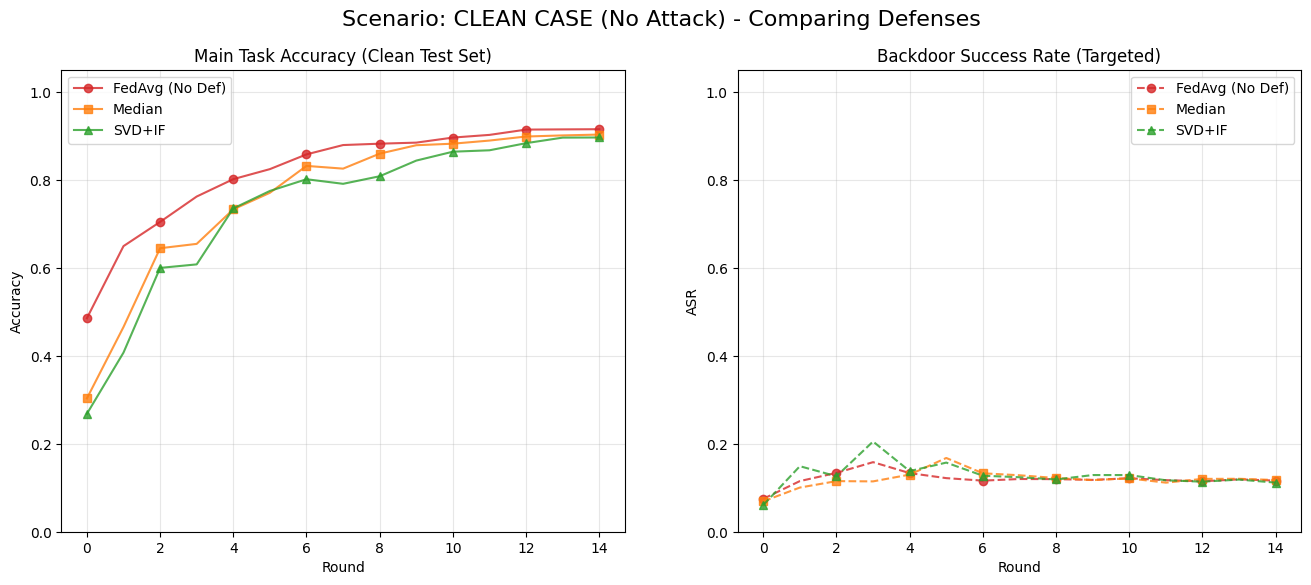

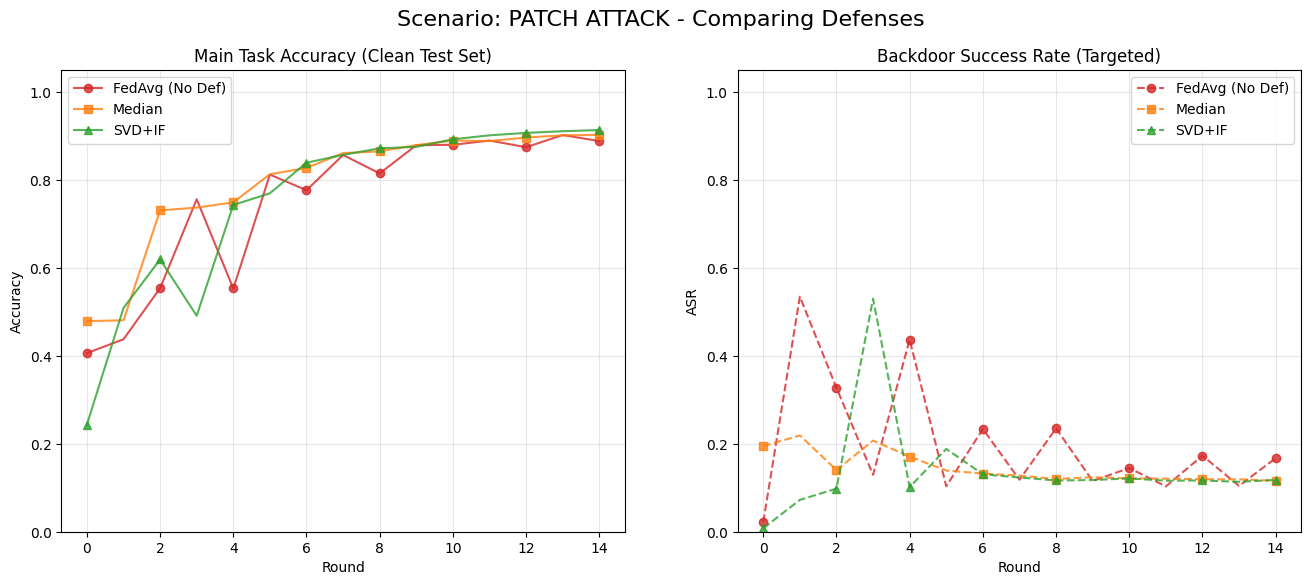

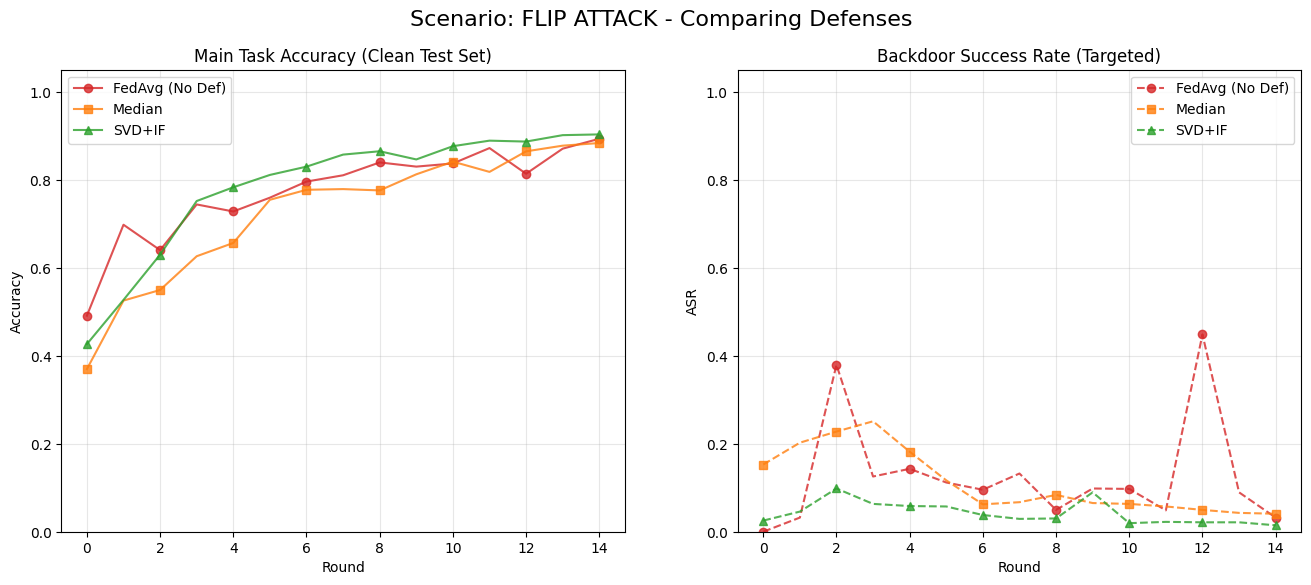

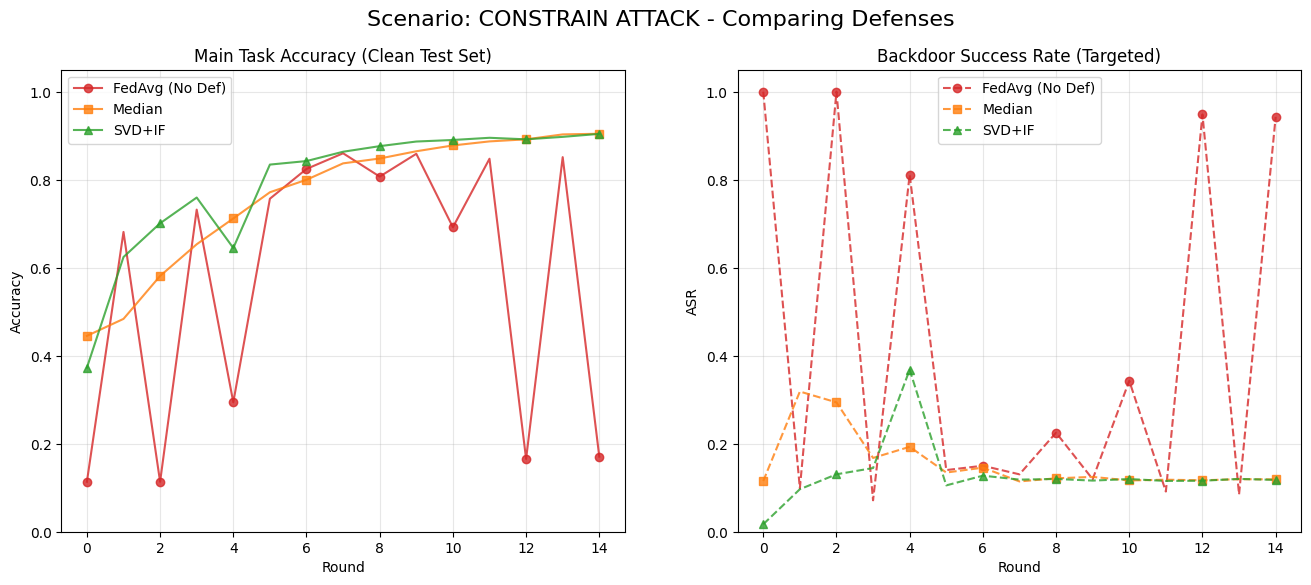

In [7]:
# ==============================================================================
# 6. Benchmark Execution & 7. Plotting
# (Consolidated into the final cell for execution and visualization)
# ==============================================================================

# Note: This cell assumes the 'run_experiment' function and all helpers
# (CNN, aggregate_median, aggregate_svd, etc.) are defined in preceding cells.

# --- Benchmark Configuration ---
# 'none' represents the clean case with no attack
attacks = ['none', 'patch', 'flip', 'constrain']
defenses = ['avg', 'median', 'svd']
results = {}

print("Starting comprehensive benchmark sweep (4 attacks x 3 defenses)...")

# --- Execution ---
for atk in attacks:
    for dfn in defenses:
        print(f"\n--- Evaluation: Attack={atk.upper()} | Defense={dfn.upper()} ---")
        # Run experiment (mal_ratio=0.2 is 20% malicious clients)
        acc, asr = run_experiment(defense=dfn, attack=atk, mal_ratio=0.2)
        results[(atk, dfn)] = {'acc': acc, 'asr': asr}

print("\nSweep complete. Generating plots...")

# --- Plotting ---
def plot_results_by_attack(results_dict, attack_types, defense_types):
    rounds = range(ROUNDS)
    
    defense_styles = {
        'avg': {'color': 'tab:red', 'marker': 'o', 'label': 'FedAvg (No Def)'},
        'median': {'color': 'tab:orange', 'marker': 's', 'label': 'Median'},
        'svd': {'color': 'tab:green', 'marker': '^', 'label': 'SVD+IF'},
    }
    
    # Create one figure per attack type (as requested: one chart per scenario)
    for atk in attack_types:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Title
        if atk == 'none':
            fig.suptitle(f"Scenario: CLEAN CASE (No Attack) - Comparing Defenses", fontsize=16)
        else:
            fig.suptitle(f"Scenario: {atk.upper()} ATTACK - Comparing Defenses", fontsize=16)
            
        # Plot metrics for all defenses on this attack
        for dfn in defense_types:
            style = defense_styles[dfn]
            res = results_dict[(atk, dfn)]
            
            # 1. Main Task Accuracy
            ax1.plot(rounds, res['acc'], 
                     label=style['label'], color=style['color'], marker=style['marker'], 
                     markevery=2, alpha=0.8)
            
            # 2. Attack Success Rate (ASR)
            # ASR in the clean case ('none') acts as a False Positive Rate.
            ax2.plot(rounds, res['asr'], 
                     label=style['label'], color=style['color'], marker=style['marker'], 
                     markevery=2, linestyle='--', alpha=0.8)

        # --- Formatting Ax1 (Clean Acc) ---
        ax1.set_title("Main Task Accuracy (Clean Test Set)")
        ax1.set_xlabel("Round")
        ax1.set_ylabel("Accuracy")
        ax1.set_ylim(0, 1.05)
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # --- Formatting Ax2 (ASR) ---
        ax2.set_title("Backdoor Success Rate (Targeted)")
        ax2.set_xlabel("Round")
        ax2.set_ylabel("ASR")
        ax2.set_ylim(0, 1.05)
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.show()

plot_results_by_attack(results, attacks, defenses)